In [117]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing
from pysr import pysr, best, get_hof, best_callable, best_tex

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min, x_max, nbins, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [3]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [4]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [5]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        plt.style.use("dark_background")
        #(n, bins, patches) = plt.hist(samples, log=True, bins=nbins, 
        #                                 label="data", histtype="step")
        n, bins = np.histogram(samples, bins=nbins)
        #plt.scatter(binss[:nbins],n)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [6]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [7]:
def prob2event(x):
    x = np.array(x)
    x.reshape(NBINS)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(NBINS)
    return x

In [8]:
def plot1(X, Y):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob", c="orange")
    plt.legend()
    plt.show()

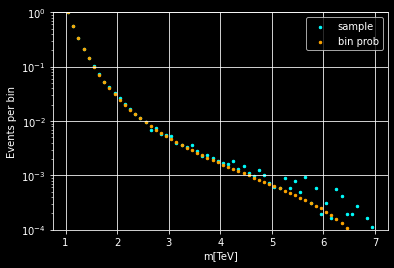

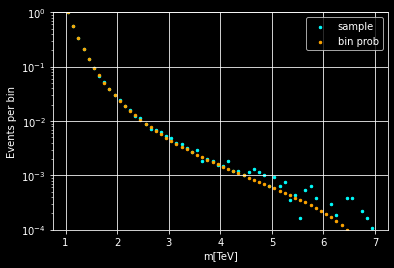

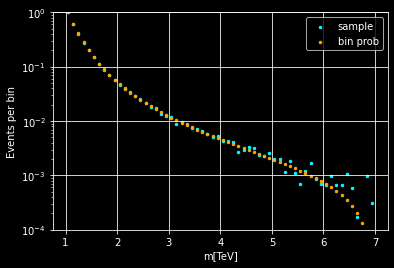

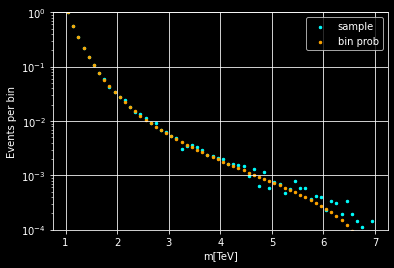

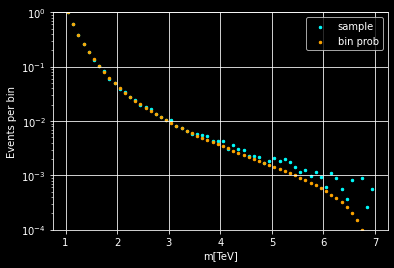

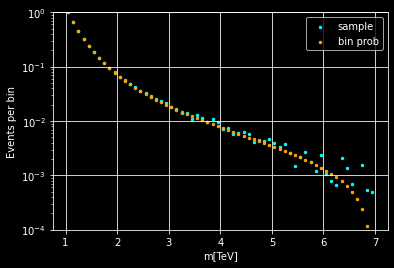

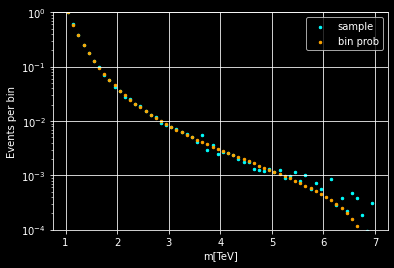

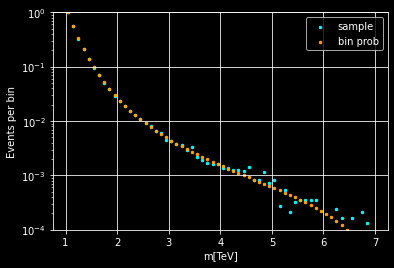

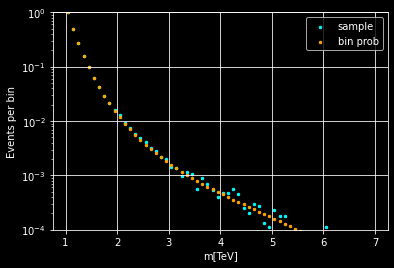

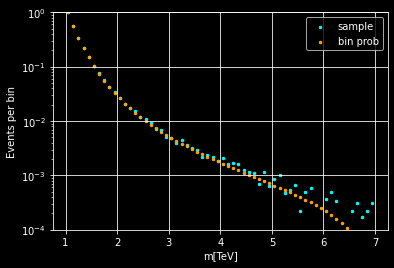

In [9]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [ ]:
# Try Symbolic Regression

In [11]:
print(Y.shape)

(10000, 60, 1)


In [119]:
X_test,Y_test,binsc= data_gen(1.2,1.8,NE,1,f,scaled=True)
xx = np.linspace(1,10,num=60)
yy = np.exp(-xx)
X_sr = np.zeros((NP, NBINS))
W_sr = np.zeros((NP, NBINS))
Y_sr = Y[:,:,0]
for i in range(NP):
    W_sr[i] = Y_test[::-1]
    X_sr[i] = binsc
print(X_sr.shape, Y_sr.shape, W_sr.shape)

(10000, 60) (10000, 60) (10000, 60)


In [120]:
print(X_sr.flatten().shape)
print(Y_sr.flatten().shape)
print(W_sr.flatten().shape)

(600000,)
(600000,)
(600000,)


In [121]:
N = 120
equations = pysr(X_sr.flatten()[:N], Y_sr.flatten()[:N], weights=W_sr.flatten()[:N], niterations=5,
        binary_operators=["plus", "sub", "mult", "pow"],
        unary_operators=["exp","logm"])

Running on julia -O3 -p 4 /tmp/tmpd2l6n2_l/runfile.jl
Started!

Cycles per second: 2.400e+04
Progress: 4 / 20 total iterations (20.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           8.167e-05  0.000e+00  0.001563
9           2.216e-06  4.008e-01  plus(pow(exp(mult(exp(x0), -0.46157986)), x0), 0.0010769402)
11          1.591e-06  1.656e-01  pow(sub(exp(sub(1.5130451, exp(x0))), -0.0027985494), pow(1.0251335, x0))
13          1.591e-06  -0.000e+00  pow(sub(exp(sub(1.5130451, exp(x0))), mult(-0.0024511572, 1.1417258)), pow(1.0251335, x0))
20          1.349e-06  2.360e-02  exp(mult(sub(x0, pow(-0.045393944, pow(0.319255, pow(x0, pow(plus(x0, 1.8512356), 1.5373746))))), pow(sub(0.2680456, x0), 0.7096936)))


Cycles per second: 1.470e+04
Progress: 5 / 20 total iterations (25.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           8.167e-05  0.000e+00  0.001563
9       

In [122]:
def testsr1(lowp, highp, ne=NE, plot=True, equations=equations):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    print(best(equations))
    Y_hat = best_callable(equations)(binsc)
    print(sum(Y_hat))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="SR predict bin prob", c="red")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

Piecewise((1, Eq(x0, 0.22285266)), (1.00344218874006, Eq(x0, 0)), (1, Eq((x0 - 0.22285266)*Abs(x0 - 0.22285266)**0.5443294, 0)), (exp(-(0.0349111**(0.32017177**(x0*Abs(x0)**4.0278187)) + x0)*(x0 - 0.22285266)*Abs((x0 - 0.22285266)**2.5443294/Abs(x0 - 0.22285266))**(0.57589173**x0)/Abs((x0 - 0.22285266)**1.0)), True))
0.9996797216623052


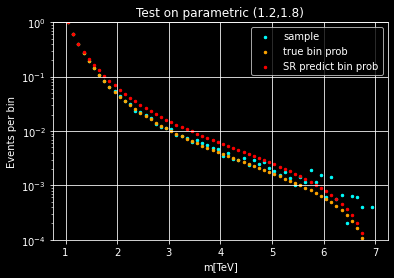

In [123]:
_ = testsr1(1.2, 1.8, equations=equations)

In [124]:
print(best_tex())

\begin{cases} 1 & \text{for}\: x_{0} = 0.22285266 \\1.00344218874006 & \text{for}\: x_{0} = 0 \\1 & \text{for}\: \left(x_{0} - 0.22285266\right) \left|{x_{0} - 0.22285266}\right|^{0.5443294} = 0 \\e^{- \frac{\left(0.0349111^{0.32017177^{x_{0} \left|{x_{0}}\right|^{4.0278187}}} + x_{0}\right) \left(x_{0} - 0.22285266\right) \left|{\frac{\left(x_{0} - 0.22285266\right)^{2.5443294}}{\left|{x_{0} - 0.22285266}\right|}}\right|^{0.57589173^{x_{0}}}}{\left|{\left(x_{0} - 0.22285266\right)^{1.0}}\right|}} & \text{otherwise} \end{cases}
